In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
# from imblearn.over_sampling import RandomOverSampler 
import numpy as np
import pandas as pd
import os, cv2
import tensorflow as tf
from PIL import Image
import uuid
import shutil
from PIL import ImageOps
import random
from keras.preprocessing.image import ImageDataGenerator
from skimage import io

In [2]:
len(tf.config.list_physical_devices('GPU'))>0

True

In [3]:
sdir=r'E:\Corneal_Ulcer\2.0'
aug_dir=os.path.join(sdir,'augmented_grade')
datasets = [aug_dir]
output = []
class_names = ['grade 0', 'grade 1','grade 2', 'grade 3', 'grade 4']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}


for dataset in datasets:
   images = []
   labels = []

        # Iterate through each folder corresponding to a category
   for folder in os.listdir(dataset):
    label = class_names_label[folder]
               # Iterate through each image in our folder
    for file in os.listdir(aug_dir+"/"+folder):
               # Get the path name of the image
      # print(file)
       img_path = os.path.join(os.path.join(dataset, folder), file)

       image = cv2.imread(img_path)
       #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
       image = cv2.resize(image, (128,128))
       images.append(image)
       labels.append(label)
   imagess = np.array(images, dtype = 'float32')
   labelss = np.array(labels, dtype = 'int32')

   train_images=imagess
   train_labels=labelss

In [4]:
from sklearn.model_selection import train_test_split
gpu_device = tf.config.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(gpu_device, True)

with tf.device('/GPU:0'):
    X_train, X_test,Y_train,Y_test= train_test_split(train_images,train_labels,test_size=0.25, shuffle= True, random_state=42)


In [5]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
num_class=5

gpu_device = tf.config.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(gpu_device, True)

with tf.device('/GPU:0'):

  inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

  conv1_1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
  conv1_2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1_1)
  pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1_2)

  conv2_1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
  conv2_2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2_1)

  pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2_2)

  conv3_1 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
  conv3_2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3_1)
  conv3_3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3_2)

  pool3 = tf.keras.layers.MaxPooling2D((2, 2))(conv3_3)

  conv4_1 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
  conv4_2 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4_1)
  conv4_3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4_2)
  pool4 = tf.keras.layers.MaxPooling2D((2, 2))(conv4_3)


  conv5_1 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool4)
  conv5_2 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv5_1)
  conv5_3 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv5_2)
  pool5 = tf.keras.layers.MaxPooling2D((2, 2))(conv5_3)

  conv6_1 = tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool5)
  conv6_2 = tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6_1)
  # c6_3 = tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6_2)

  pool6 = tf.keras.layers.MaxPooling2D((2, 2))(conv6_2)

  conv7_1 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool6)
  conv7_2 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7_1)
  conv7_3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7_2)


  
  batchNor = tf.keras.layers.BatchNormalization()(conv7_3)
  pool7 = tf.keras.layers.MaxPooling2D((2, 2))(batchNor)
  dropOut = tf.keras.layers.Dropout(0.5)(pool7)
  flatten1=tf.keras.layers.Flatten()(dropOut)


  outputs = tf.keras.layers.Dense(num_class, activation='softmax')(flatten1)


# Use a learning rate scheduler
#   lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=0.001,
#     decay_steps=10000,
#     decay_rate=0.9
# )

  model_p = tf.keras.Model(inputs=[inputs], outputs=[outputs])
  # model_p.compile(optimizer=keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004), #lr=0.005
  #               loss='CategoricalCrossentropy',
  #               metrics=['accuracy'])

  Checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='Custom_model.h5',
                                                  monitor='val_loss', mode='max',
                                                 verbose=0)
  File = 'CornealUlcer'
  callback = [Checkpoint, 
             tf.keras.callbacks.EarlyStopping(patience = 10, monitor= "val_accuracy",verbose=1),
             tf.keras.callbacks.TensorBoard(log_dir = "logs/{}".format(File))]

  model_p.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    # optimizer="adam",
    metrics=['accuracy']
  )
  model_p.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                             

In [6]:

from tensorflow.keras.utils import to_categorical
gpu_device = tf.config.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(gpu_device, True)

with tf.device('/GPU:0'):
    Y = to_categorical(Y_train, num_classes =5)
    y_test = to_categorical(Y_test, num_classes=5)



In [11]:
tf.keras.utils.plot_model(
    model_p,
    to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [7]:
history2 = model_p.fit(x=X_train,y=Y,validation_split=0.20,batch_size = 18, epochs = 100,
                    callbacks=[callback])

Epoch 1/100
400/400 [==============================] - 22s 45ms/step - loss: 2.5196 - accuracy: 0.2332 - val_loss: 2.0395 - val_accuracy: 0.2861
Epoch 2/100
400/400 [==============================] - 18s 44ms/step - loss: 2.0797 - accuracy: 0.2826 - val_loss: 1.8353 - val_accuracy: 0.2778
Epoch 3/100
400/400 [==============================] - 18s 44ms/step - loss: 2.0135 - accuracy: 0.2862 - val_loss: 1.5301 - val_accuracy: 0.3250
Epoch 4/100
400/400 [==============================] - 18s 44ms/step - loss: 1.9155 - accuracy: 0.3031 - val_loss: 1.4374 - val_accuracy: 0.3667
Epoch 5/100
400/400 [==============================] - 18s 44ms/step - loss: 1.8703 - accuracy: 0.3014 - val_loss: 1.4095 - val_accuracy: 0.3800
Epoch 6/100
400/400 [==============================] - 18s 44ms/step - loss: 1.7429 - accuracy: 0.3249 - val_loss: 1.6982 - val_accuracy: 0.3239
Epoch 7/100
400/400 [==============================] - 18s 44ms/step - loss: 1.6934 - accuracy: 0.3299 - val_loss: 2.5618 - val_ac

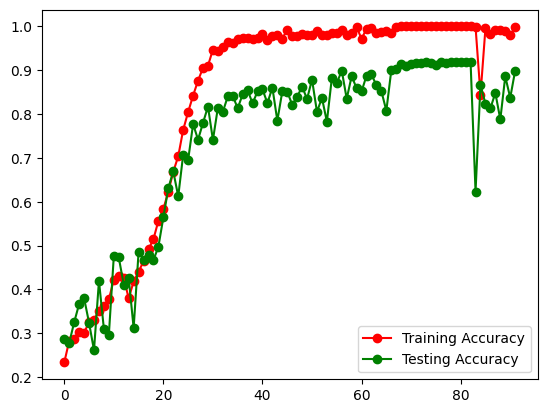

In [8]:
plt.plot(history2.history["accuracy"] , 'ro-' , label = "Training Accuracy")
plt.plot(history2.history["val_accuracy"] , 'go-' , label = "Testing Accuracy")
plt.legend()
plt.show()

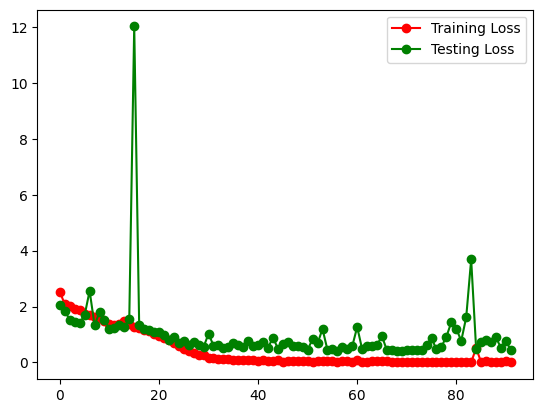

In [9]:
plt.plot(history2.history["loss"] , 'ro-' , label = "Training Loss")
plt.plot(history2.history["val_loss"] , 'go-' , label = "Testing Loss")
plt.legend()
plt.show()

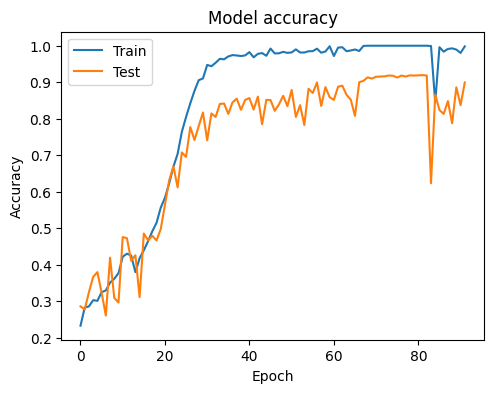

In [10]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

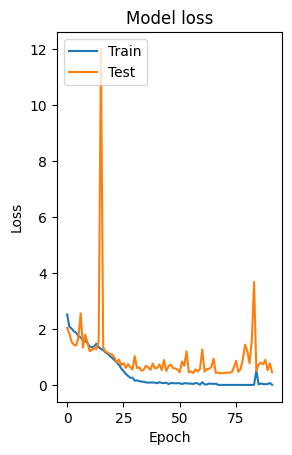

In [11]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

94/94 [==============================] - 1s 14ms/step


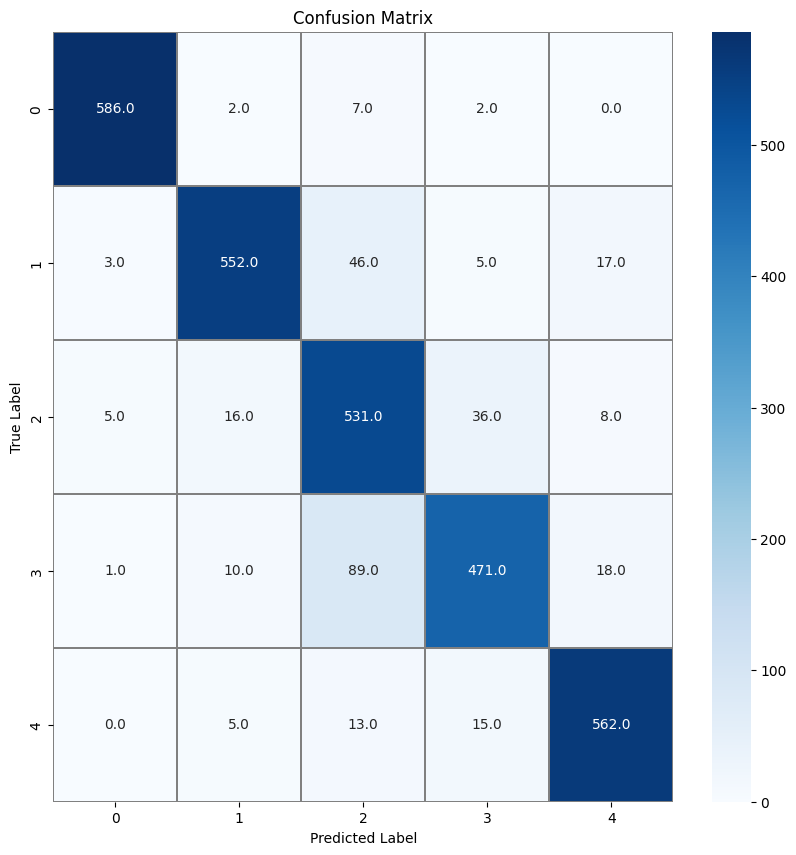

In [15]:
from sklearn.metrics import confusion_matrix, classification_report
# Predict the values from the test set
y_pred = model_p.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_test, y_pred_classes) 

# plot the confusion matrix
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [16]:
class_names = {0: 'grade 0', 1: 'grade 1', 2: 'grade 2', 3: 'grade 3', 4: 'grade 4'}
# Predict the values from the test set
y_pred = model_p.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1)

target_names = [f"{class_names[i]}" for i in range(5)]
print(classification_report(Y_test, y_pred_classes, target_names=target_names))

94/94 [==============================] - 1s 14ms/step
              precision    recall  f1-score   support

     grade 0       0.98      0.98      0.98       597
     grade 1       0.94      0.89      0.91       623
     grade 2       0.77      0.89      0.83       596
     grade 3       0.89      0.80      0.84       589
     grade 4       0.93      0.94      0.94       595

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.90      0.90      0.90      3000



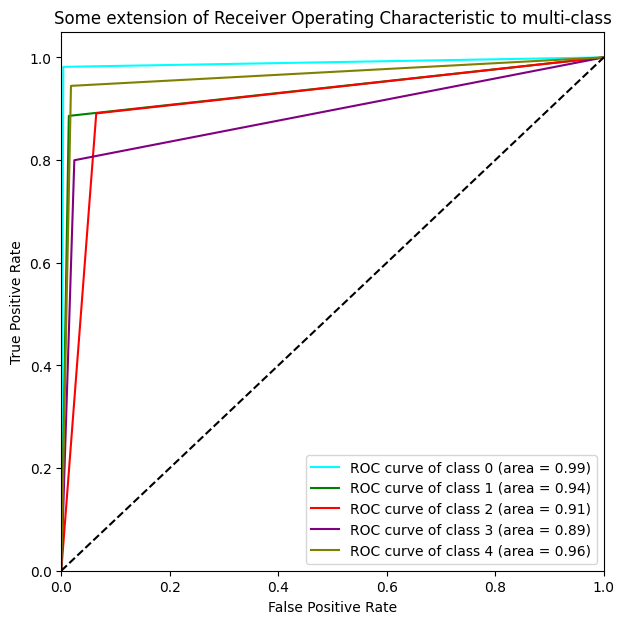

In [17]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from itertools import cycle


# Binarize the output
y_test_bin = label_binarize(Y_test, classes=[0, 1, 2, 3, 4])
y_pred_bin = label_binarize(y_pred_classes, classes=[0, 1, 2, 3, 4])
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(7, 7))

colors = cycle(['aqua', 'green', 'red', 'purple', 'olive'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver Operating Characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [18]:
model_p.load_weights('custom_model.h5')

In [19]:
loss, acc = model_p.evaluate(X_test, y_test, verbose=2)

94/94 - 2s - loss: 0.4347 - accuracy: 0.9007 - 2s/epoch - 17ms/step


In [24]:
%pip install git+https://github.com/paulgavrikov/visualkeras

  Cloning https://github.com/paulgavrikov/visualkeras to c:\users\19301070\appdata\local\temp\pip-req-build-fyjfl__c
  Resolved https://github.com/paulgavrikov/visualkeras to commit cd169b81be347e2090353ad6fe2bd2e1f4020cf4
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached aggdraw-1.3.16-cp38-cp38-win_amd64.whl (43 kB)
  Created wheel for visualkeras: filename=visualkeras-0.0.2-py3-none-any.whl size=13822 sha256=a8fcea17448c37c47f9250ce2ab438167ea75700da5da1336266e6d7ae5611f8
  Stored in directory: C:\Users\19301070\AppData\Local\Temp\pip-ephem-wheel-cache-55orj2yt\wheels\e6\fe\80\74c54ccb79205ab57079259bc349e1629373e811e1c82ed535
Successfully built visualkeras
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/paulgavrikov/visualkeras 'C:\Users\19301070\AppData\Local\Temp\pip-req-build-fyjfl__c'


In [42]:
import visualkeras

ValueError: Could not save to JPEG for display

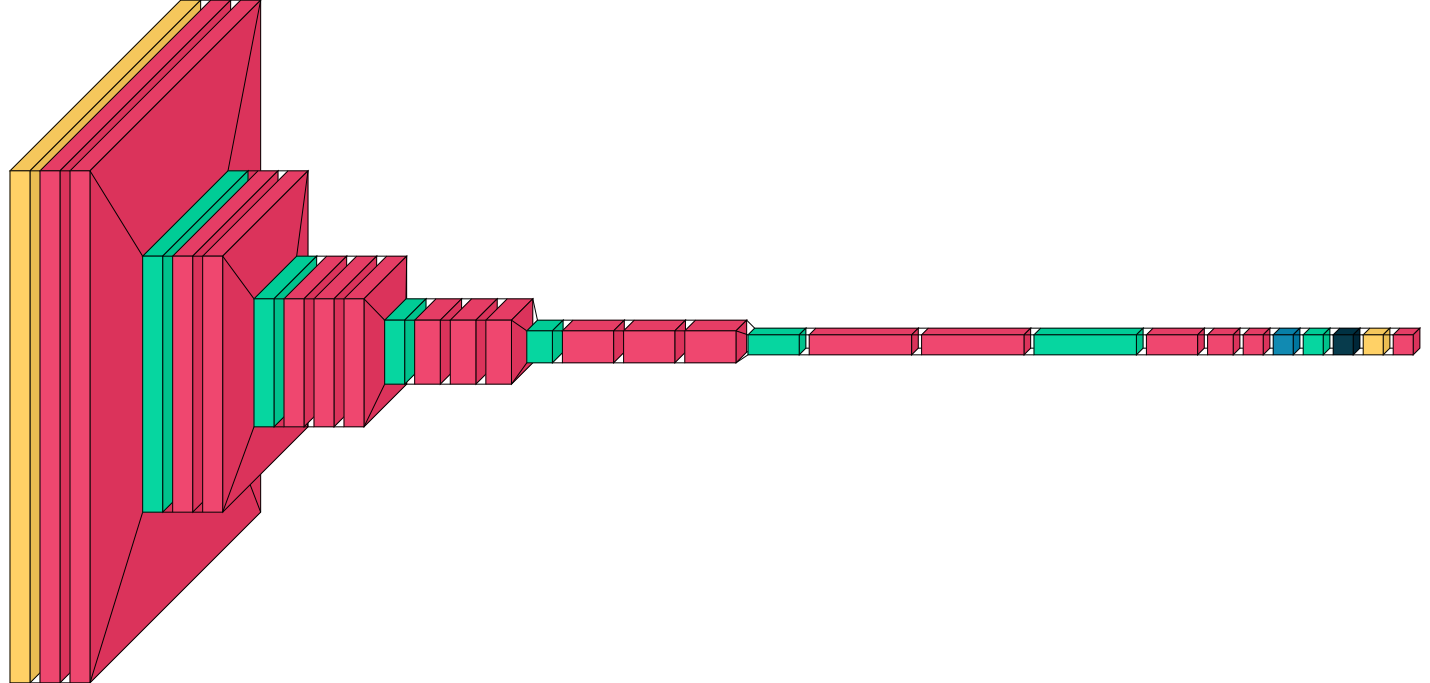

In [53]:
visualkeras.layered_view(model_p,to_file='output.png')

#### yellow= ZeroPadding2D
#### red= Conv2D
#### green = MaxPooling2D
#### blue= Flatten 
#### black = Dense 
#### yellow= Dropout

In [ ]:
from PIL import ImageFont

font = ImageFont.truetype("arial.ttf", 32) 
visualkeras.layered_view(model_p, legend=True, font=font,to_file='output.png')  # font is optional!